### SNA & MDS

In [18]:
import operator
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

In [19]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

In [20]:
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.manifold import MDS
from pygsp import graphs

In [21]:
import nltk
from nltk import bigrams
import collections

In [22]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [23]:
# Files definition
comment_freq = 'output\comment_cooc_freq.xlsx'
comment_lift = 'output\comment_cooc_lift.xlsx'
comment_jacc = 'output\comment_cooc_jacc.xlsx'

In [24]:
brands = ['เมจิ', 'ไทยเดนมาร์ค', 'แดรี่โฮม', 'โฟร์โมสต์', 'โชคชัย', 'หนองโพ', 'เอ็มมิลค์']

เปิดไฟล์ที่ได้จากขั้นตอน Data Prep

In [25]:
cooc_matrix_freq = pd.read_excel(comment_freq,index_col=0)
#cooc_matrix_lift = pd.read_excel(comment_lift,index_col=0)
cooc_matrix_jacc= pd.read_excel(comment_jacc,index_col=0)

In [26]:
cooc_matrix_freq.shape

(338, 338)

### MDS Visualization

In [27]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html

In [28]:
def jaccard_precompute(df,i,j):
    ## หา Jaccard เทียบแถวแนวนอน ใช้เฉพาะในหน้านี้ 
    # เนื่องจากให้โปรแกรมยืดหยุ่นกรณีจะเตรียมข้อมูลเข้า Euclidean ของ MDS
    a = pd.DataFrame(df.iloc[:,i])
    b = pd.DataFrame(df.iloc[:,j])
    slice_df = pd.concat([a,b], axis=1, join="inner")
    slice_df.columns = ['A','B']
    a_in_b = slice_df[(slice_df.A>0)&(slice_df.B>0)]
    a_occur = slice_df[(slice_df.A>0)]
    b_occur = slice_df[(slice_df.B>0)]
    jacc_index = a_in_b.shape[0]/(a_occur.shape[0]+b_occur.shape[0]-a_in_b.shape[0])
    return jacc_index

In [59]:
def create_MDS_perceptual_map(df, attrName, dissim):
    embedding = MDS(n_components=2, dissimilarity=dissim)
    mds_coord = embedding.fit_transform(df)
    fig, ax=plt.subplots(figsize=(10,5))
    ax.set_title(f'MDS Perceptual map: {attrName}', fontsize=20)
    plt.scatter(mds_coord[:,0],mds_coord[:,1])
    labels=df.index
    for label,x,y in zip(labels, mds_coord[:,0], mds_coord[:,1]):
        plt.annotate(label,(x,y), fontsize=13)
    plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
    plt.axvline(x=0, color='k', linestyle='-', linewidth=1)
    plt.xlabel('PC1', fontsize=16)
    plt.ylabel('PC2', fontsize=16)
    plt.grid(True)
    plt.show()
    return mds_coord.shape, embedding

In [30]:
# Co-occurrence
def gen_precomputed_matrix(df):
    precomputed_matrix = pd.DataFrame(index=df.columns,columns=df.columns).fillna(0)
    for i in range(0,len(precomputed_matrix.columns)):
        for j in range(0,len(precomputed_matrix.columns)):
            precomputed_matrix.iloc[i,j] = jaccard_precompute(df,i,j)
    return precomputed_matrix

In [31]:
# Transpose frequency into Attribute Rating Format for Euclidean distance MDS
#cooc_matrix_freq = cooc_matrix_freq[brands].T
#cooc_matrix_freq.drop(axis=1, columns=brands, inplace=True)

# Transpose frequency into Attribute Rating Format for precompute MDS
cooc_matrix_freq = cooc_matrix_freq[brands]
cooc_matrix_freq.drop(brands, axis=0, inplace=True)
cooc_matrix_freq = cooc_matrix_freq.T

In [32]:
dissim = ['euclidean', 'precomputed']
promotions = ['แจก','แชร์','แถม','แพคคู่','โฆษณา','โปรโมชั่น','การลดราคา','ชิม','รีวิว','ลดราคา']
mixtures = ['เวย์','เวย์โปรตีน','แคลเซียม','แคลเซี่ยม','แมกนีเซียม','แลกโตส','แล็กโต๊ส','แลคโตส','แลคติก','โซเดียม','โปรตีน','โพแทสเซียม','โฟเลต','โฟลิค'
                  ,'ไขมัน','ไขมัน 0%','ไขมันต่ำ','กรดไขมัน','กรดอะมิโน','กลูโคส','คาร์โบไฮเดรต','ธาตุเหล็ก','นมข้น','นมผง','นมวัว','น้ำ','น้ำเชื่อม','น้ำตาล','น้ำตาลเทียม'
                  ,'น้ำตาลทราย','น้ำตาลทรายแดง','น้ำนม','น้ำผึ้ง','ปริมาณ','ผสม','วิตามิน','ส่วนผสม','สูตร']

In [33]:
precomMat_promotion = gen_precomputed_matrix(cooc_matrix_freq[promotions].T)
precomMat_mixtures = gen_precomputed_matrix(cooc_matrix_freq[mixtures].T)
precomMat_overall = gen_precomputed_matrix(cooc_matrix_freq.T)

In [52]:
precomMat_overall

,เมจิ,ไทยเดนมาร์ค,แดรี่โฮม,โฟร์โมสต์,โชคชัย,หนองโพ,เอ็มมิลค์
เมจิ,1.000000,0.642023,0.426724,0.669323,0.480349,0.559322,0.238938
ไทยเดนมาร์ค,0.642023,1.000000,0.497512,0.683983,0.478469,0.632850,0.237624
แดรี่โฮม,0.426724,0.497512,1.000000,0.399061,0.434211,0.487952,0.314050
โฟร์โมสต์,0.669323,0.683983,0.399061,1.000000,0.507389,0.658416,0.216749
โชคชัย,0.480349,0.478469,0.434211,0.507389,1.000000,0.545455,0.325397
หนองโพ,0.559322,0.632850,0.487952,0.658416,0.545455,1.000000,0.256410
เอ็มมิลค์,0.238938,0.237624,0.314050,0.216749,0.325397,0.256410,1.000000


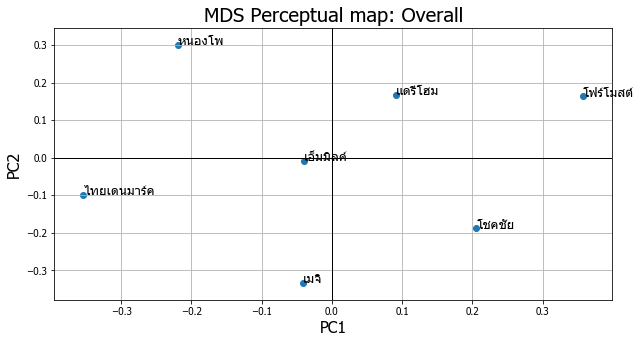

((7, 2), MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
     n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0))

In [60]:
create_MDS_perceptual_map(precomMat_overall,'Overall', dissim[1])

In [ ]:
#emb.stress_
#emb.n_iter_
#emb.dissimilarity_matrix_

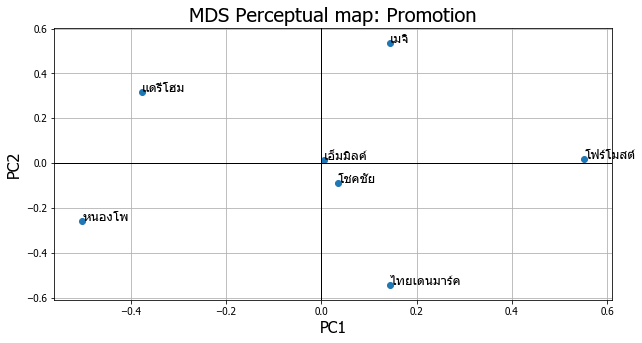

((7, 2), MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
     n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0))

In [61]:
create_MDS_perceptual_map(precomMat_promotion,'Promotion', dissim[1])

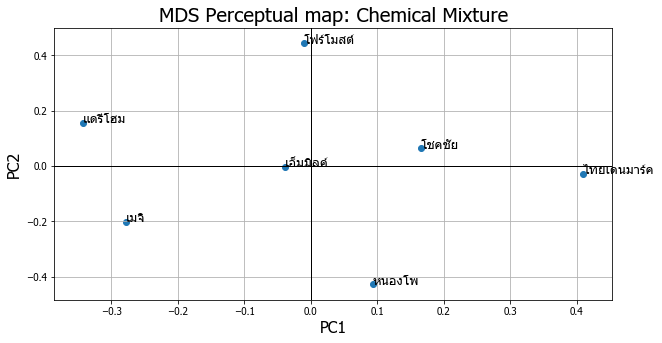

((7, 2), MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
     n_components=2, n_init=4, n_jobs=None, random_state=None, verbose=0))

In [62]:
create_MDS_perceptual_map(precomMat_mixtures,'Chemical Mixture', dissim[1])

สร้างกราฟ

In [40]:
def stackForGraph(cm):
    stack_matrix = pd.DataFrame(cm.stack())
    stack_matrix.index.names = ['item', 'relatedItem']
    stack_matrix.columns = ['coocValue']
    stack_matrix.reset_index(inplace=True)
    stack_matrix = stack_matrix[(stack_matrix.item != stack_matrix.relatedItem)]
    stack_matrix.sort_values(by='coocValue',ascending=False).head(10)
    return stack_matrix

In [41]:
def plot_pandas_graph(df):
    fig, ax=plt.subplots(figsize=(15,8))
    G=nx.from_pandas_edgelist(df,source='item',target='relatedItem')
    nx.draw(G,with_labels=True, font_family='Tahoma',node_color='yellow')
    plt.show()
    return G

In [42]:
def create_upperTriMatrix(df):
    df.values[np.tril(np.ones(df.shape)).astype(np.bool)] = 0
    return df

Upper matrix plot (Co-occurence without normalization)

In [43]:
#cooc_matrix_ = create_upperTriMatrix(cooc_matrix)
#cooc_matrix_2 = stackForGraph(cooc_matrix_)

cooc_matrix_2 = stackForGraph(cooc_matrix_jacc)
cooc_matrix_2_filter = cooc_matrix_2[(cooc_matrix_2.coocValue >= 0.01)&(cooc_matrix_2.item.isin(brands))]
#cooc_matrix_2_filter = cooc_matrix_2[(cooc_matrix_2.coocValue >= 0.4)]

In [45]:
cooc_matrix_2.tail(10)

,item,relatedItem,coocValue
114233,โด๊บ,สัปปะรด,0.0
114234,โด๊บ,แมกนีเซียม,0.0
114235,โด๊บ,โรคท้องร่วง,0.0
114236,โด๊บ,สยามพารากอน,0.0
114237,โด๊บ,ห้างร้าน,0.0
114238,โด๊บ,โรคขาดอาหาร,0.0
114239,โด๊บ,ช่องแช่แข็ง,0.0
114240,โด๊บ,โยเกิร์ท,0.0
114241,โด๊บ,พารากอน,0.0
114242,โด๊บ,พาราไดซ์,0.0


C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


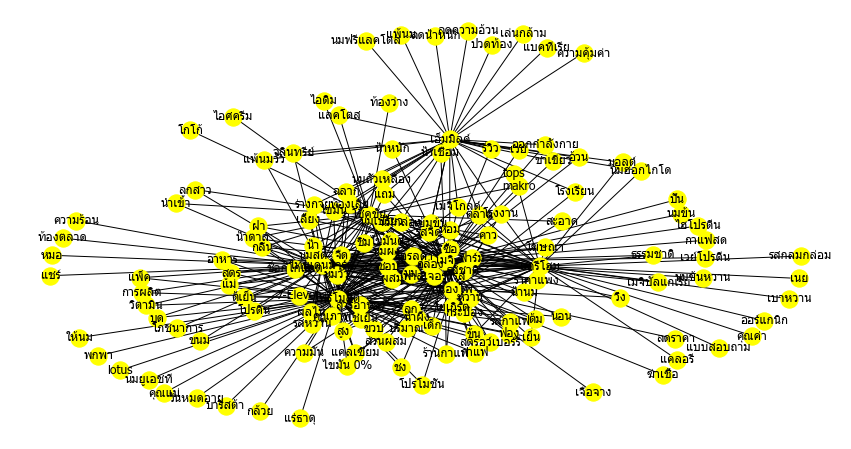

In [46]:
G2 = plot_pandas_graph(cooc_matrix_2_filter)

In [47]:
from community import community_louvain
partition = community_louvain.best_partition(G2)

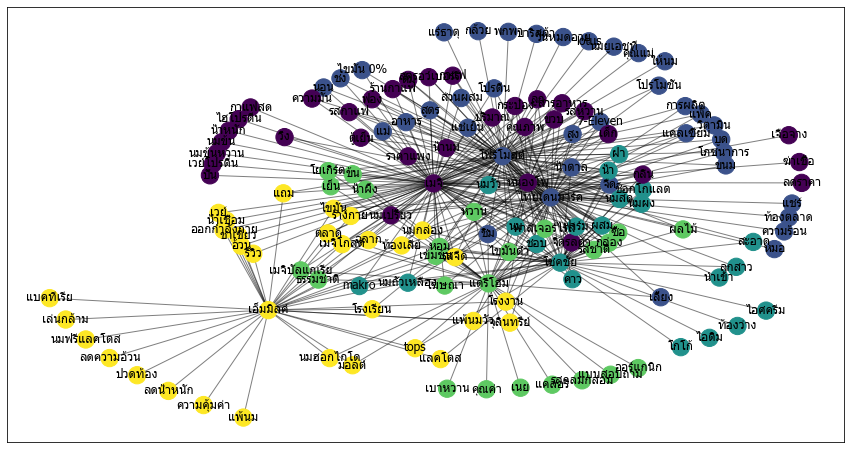

In [48]:
fig, ax=plt.subplots(figsize=(15,8))
G2=nx.from_pandas_edgelist(cooc_matrix_2_filter,source='item',target='relatedItem')
pos = nx.kamada_kawai_layout(G2)
nx.draw_networkx_nodes(G2,pos,partition.keys(),node_color=list(partition.values()))
nx.draw_networkx_edges(G2, pos, alpha=0.5)
nx.draw_networkx_labels(G2,pos,font_family='Tahoma')
plt.show()